# Simulazione GNSS: Stima della posizione da pseudorange con visualizzazione animata e filtraggio  
In un modello semplificato (2 dimensioni), cerchiamo di stimare la posizione di un utente attraverso delle misure rumorose di pseudorange di satelliti in orbita.  
Tentiamo di ricostruire la posizione in due modi differenti: minimizzando l'errore medio (LSQ) e attraverso un filtro di Kalman.


In [781]:
import numpy as np
import matplotlib.pyplot as plt

Definiamo i parametri che andremo ad utilizzare nel corso del progetto

In [782]:
radius = 1.0 # Orbit radius
N_satellites = 3 # Number of satellites
theta_0 = np.linspace(0, 2 * np.pi, N_satellites + 1)[:-1] # Starting angles (4 satellites)
my_latitude = 0.4 # Latitude of the observer
my_longitude = 0.3 # Longitude of the observer
omega = 2 * np.pi * 0.01 # Angular velocity of the satellites
sigma = 0.01 # Standard deviation of the noise
Tmax = 20 # Maximum time for the simulation
dt = 0.1 # Time step for the simulation

angles = np.linspace(0, 2 * np.pi, 100) # Angles for the plot
t = np.arange(0, Tmax, dt) # Time for the plot


La seguente funzione verrà utilizzata per convertire coordinate polari (r, theta) in coordinate cartesiane (x,y)

In [783]:
def polar_to_cartesian(theta, radius=1.0):
    """Convert polar coordinates to Cartesian coordinates."""
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y

Introduciamo due strutture dati: una per registrare una posizione nel modello 2D, l'altra per descrivere un satellite, includendo delle funzioni ausiliarie.

In [784]:
class Position:
    def __init__(self, c1, c2, polar=False):
        if polar is False:
            self.x, self.y = c1, c2
            self.radius = np.sqrt(c1**2 + c2**2)
            self.theta = np.arctan2(c2, c1)
        else:
            self.theta = c1
            self.radius = c2
            self.x = c2 * np.cos(c1)
            self.y = c2 * np.sin(c1)
    
    # Sum and difference of two positions
    def __add__(self, other):
        return Position(self.x + other.x, self.y + other.y)
    def __sub__(self, other):
        return Position(self.x - other.x, self.y - other.y)
    
    # Compute the distance between two positions
    def distance(self, other):
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
class Satellite:
    def __init__(self, theta, omega, radius=1.0):
        self.position = Position(theta, radius, polar=True)
        self.angular_velocity = omega
    
    # Update the position of the satellite based on its angular velocity and the time step dt
    def update(self, dt):
        self.position.theta += self.angular_velocity * dt
        self.position.x = self.position.radius * np.cos(self.position.theta)
        self.position.y = self.position.radius * np.sin(self.position.theta)

    # Compute the distance from the satellite to a user position
    def distance(self, user_position):
        return self.position.distance(user_position)

Posizioniamo i satelliti equidistanti tra loro, in orbita. Assegnamo all'utente una posizione arbitraria.

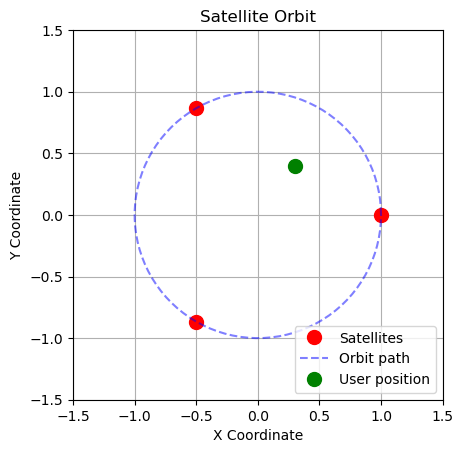

In [785]:
sat_pos = [Position(th, radius, polar=True) for th in theta_0] # Initial positions of satellites
user_pos = Position(my_longitude, my_latitude, polar=False) # Observer's position

plt.plot([a.x for a in sat_pos], [a.y for a in sat_pos], 'ro', markersize=10, label='Satellites') # Initial positions of satellites
plt.plot(np.cos(angles), np.sin(angles), 'b--', alpha=0.5, label='Orbit path') # Orbit path
plt.plot(my_longitude, my_latitude, 'go', markersize=10, label='User position') # Observer's position
ax = plt.gca()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.set_title('Satellite Orbit')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.legend(loc='lower right')
ax.grid()

Calcoliamo gli pseudorange dell'utente rispetto a ciascun satellite e stimiamo la posizione minimizzando lo scarto quadratico medio


In [786]:
distances = np.array([sat.distance(user_pos) for sat in sat_pos]) # Distances from satellites to observer
noise = np.random.normal(0, sigma, N_satellites) # Noise for pseudoranges
noisy_pseudoranges = distances + noise # Noisy pseudoranges

estimated_pos = Position(0, 0) # Initial guess for the observer's position

def cost_function(est_pos, sat_pos, noisy_pseudoranges):
    """Objective function to minimize."""
    try:
        estimated_distances = np.array([sat.distance(est_pos) for sat in sat_pos]) # Distances from satellites to estimated position
    except:
        pos = [est_pos.x, est_pos.y]
        estimated_distances = np.linalg.norm(sat_pos - pos, axis=1) # Distances from satellites to estimated position
    return np.linalg.norm(estimated_distances - noisy_pseudoranges) # L2 norm of the difference

lsq_cost_wrapper = lambda p, sat_pos, noisy_pseudoranges: cost_function(Position(p[0], p[1]), sat_pos, noisy_pseudoranges) # Wrapper for the cost function

from scipy.optimize import minimize
result = minimize(lsq_cost_wrapper, [estimated_pos.x, estimated_pos.y], args=(sat_pos, noisy_pseudoranges,), tol=1e-6)
estimated_x, estimated_y = result.x # Estimated position of the observer
print(f"Estimated Position: {round(estimated_x, 2)} {round(estimated_y, 2)}")
print("True Position:", my_longitude, my_latitude)

Estimated Position: 0.29 0.39
True Position: 0.3 0.4


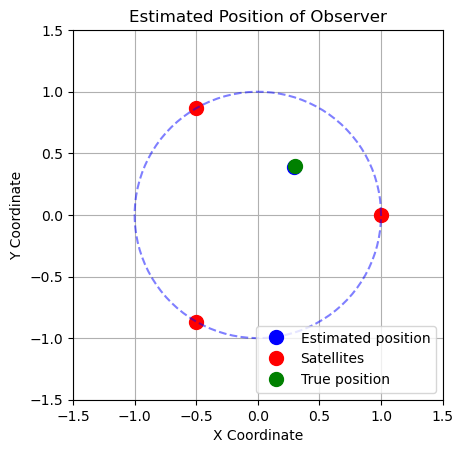

In [787]:
plt.plot(estimated_x, estimated_y, 'bo', markersize=10, label="Estimated position") # Estimated position
plt.plot([s.x for s in sat_pos], [s.y for s in sat_pos], 'ro', markersize=10, label="Satellites") # Initial positions of satellites
plt.plot(np.cos(angles), np.sin(angles), 'b--', alpha=0.5) # Orbit path
plt.plot(user_pos.x, user_pos.y, 'go', markersize=10, label="True position") # Observer's position
ax = plt.gca()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.set_title('Satellite Orbit')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.grid()
plt.title('Estimated Position of Observer')
plt.legend(loc='lower right')
plt.show()

Aggiungiamo ora l'asse temporale. I satelliti si muoveranno lungo l'orbita a velocità angolare costante (omega), mentre per l'utente possiamo scegliere una traiettoria arbitraria. La stima della posizione dell'utente deve essere eseguita continuamente.

$$x_{k+1} = x_k + v_x \, dt \qquad y_{k+1} = y_k + v_y \, dt$$
$$z_{1,k+1} = ||\mathbf{s}_{1,k} - \mathbf{x}_{k}|| + w_{1,k}$$

In [788]:
import numpy as np

# Parametri iniziali
vx = -0.05  # Velocity in x direction
vy = -0.05  # Velocity in y direction

satellites = [Satellite(theta, omega, radius) for theta in theta_0]  # Inizializza i satelliti

# Stato: posizione (x, y) e velocità (vx, vy)
state = np.array([my_longitude, my_latitude, vx, vy])  # Stato iniziale

# Matrice di transizione dello stato (A)
A = np.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Covarianza iniziale
P = np.eye(4) * 100  

# Matrice di rumore di processo (Q) - facoltativo, piccolo rumore su accelerazioni
Q = np.eye(4) * 1e-4

# Vera posizione dell'osservatore
true_pos = np.array([my_longitude, my_latitude]) 
estimated_pos = Position(my_longitude, my_latitude)  # Posizione stimata iniziale

# Posizioni iniziali dei satelliti
sat_positions = np.array([
    [sat.position.x, sat.position.y] for sat in satellites
])

# Rumore di misura
R = np.eye(len(sat_positions)) * sigma**2  

# Liste per la traiettoria
true_trajectory = []
estimated_trajectory = []

# ---- Filtro EKF aggiornato per stato 4D ----
def ekf_update(state, P, sat_positions, pseudoranges, R, A, Q):
    N = sat_positions.shape[0]
    
    # --- Predizione ---
    state_pred = A @ state
    P_pred = A @ P @ A.T + Q

    # --- Predizione delle misure ---
    predicted_pseudoranges = np.linalg.norm(sat_positions - state_pred[:2], axis=1)
    
    # --- Jacobiano H (solo rispetto a x e y) ---
    H = np.zeros((N, 4))
    for i in range(N):
        diff = state_pred[:2] - sat_positions[i]
        dist = np.linalg.norm(diff)
        if dist > 0:
            H[i, 0:2] = diff / dist
        else:
            H[i, 0:2] = np.zeros(2)
    
    # --- Residuo ---
    y = pseudoranges - predicted_pseudoranges

    # --- Matrice di innovazione ---
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    # --- Aggiornamento ---
    new_state = state_pred + K @ y
    new_P = (np.eye(4) - K @ H) @ P_pred

    return new_state, new_P

# ---- Ciclo di simulazione ----

# Prima fase: convergenza iniziale
pseudoranges = np.linalg.norm(sat_positions - true_pos, axis=1) + np.random.normal(0, sigma, len(sat_positions))
for _ in range(50):
    state, P = ekf_update(state, P, sat_positions, pseudoranges, R, A, Q)

lsq_data = []
# Poi simuliamo il movimento
for timestep in t:
    # Aggiorna la posizione vera
    true_pos += np.array([vx, vy]) * dt

    # Aggiorna le posizioni dei satelliti
    for sat in satellites:
        sat.update(dt)
    sat_positions = np.array([[sat.position.x, sat.position.y] for sat in satellites])

    # Pseudorange osservati
    pseudoranges = np.linalg.norm(sat_positions - true_pos, axis=1) + np.random.normal(0, sigma, len(sat_positions))

    # Vari iterazioni EKF (opzionale)
    for _ in range(10):
        state, P = ekf_update(state, P, sat_positions, pseudoranges, R, A, Q)

    # Salva traiettorie
    estimated_trajectory.append(state[:2].copy())  # Solo x, y

    result = minimize(lsq_cost_wrapper, [estimated_pos.x, estimated_pos.y], args=(sat_positions, noisy_pseudoranges,), tol=1e-6)
    estimated_x, estimated_y = result.x # Estimated position of the observer
    estimated_pos = Position(estimated_x, estimated_y) # Update estimated position
    lsq_data.append([estimated_x, estimated_y])  # Salva i dati LSQ
    
    #print("True Position:", true_pos)
    true_trajectory.append(true_pos.copy())  # Copia della posizione vera


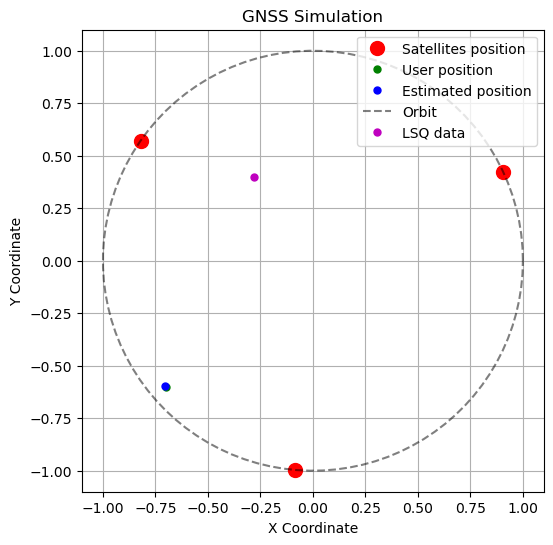

In [ ]:
from matplotlib import rcParams
import matplotlib.animation as animation

# Crea la figura e l'asse
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')
ax.set_title('GNSS Simulation')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Inizializza oggetti grafici
satellite_lines = ax.plot([], [], 'ro', markersize=10, label="Satellites position")[0] # Satellites
user_pos_line = ax.plot([], [], 'g.', markersize=10, label="User position")[0] # User position
estimated_pos_line = ax.plot([], [], 'b.', markersize=10, label="Estimated position")[0] # Estimated position
orbit_path_line = ax.plot([], [], '--', color='black', alpha=0.5, label="Orbit")[0] # Orbit path

plt.legend(loc='upper right')
plt.grid()

def update_all(i):
    """Update function for the animation."""
    # Update satellite positions
    for j, sat in enumerate(satellites):
        sat.update(dt)
    
    satellite_lines.set_data([sat.position.x for sat in satellites], [sat.position.y for sat in satellites])

    # Update user position
    user_pos_line.set_data([true_trajectory[i][0]], [true_trajectory[i][1]])

    # Update estimated position
    estimated_pos_line.set_data([estimated_trajectory[i][0]], [estimated_trajectory[i][1]])

    # Update orbit path
    orbit_path_line.set_data([np.cos(angles)], [np.sin(angles)])

    return satellite_lines, user_pos_line, estimated_pos_line, orbit_path_line

ani = animation.FuncAnimation(fig, update_all, frames=len(t), interval=50, blit=True)

ani.save("gnss_simulation.gif", writer='pillow', fps=30)


plt.show()